# Manual Model Manipulation Trick
In this kernel, we load a public Kaggle model's submission file, view it's malware infection rate over time, and modify it manually to match what train.csv's malware rate looks like over time. The original submission file scores Public LB 0.689 and Private LB 0.635. After correction, the updated file scores Public LB 0.693 and Private LB 0.750.  
  
I used this trick during the competition to increase Public LB score. But it wasn't until after the competition's end that I learned how to increase Private LB score. In the private test dataset, all computers on and after November 20, 2018 have `HasDetections=0` approximately. (Why is this?)

In [1]:
# IMPORT LIBRARIES
import pandas as pd, numpy as np, os, gc
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta

# Load files and time stamps
We will load the output from  [Hung The Nguyen's][1] kernel [here][2]. And attach time stamps.

[1]: https://www.kaggle.com/hung96ad
[2]: https://www.kaggle.com/hung96ad/new-blend

In [2]:
# Lower detection rate for August and September computers
AdjustPublicScore = True
# 0=No, 1=Remove Nov 20,21,22,23,24,25, 2=Downward trend Nov 20,21,22,23,24,25
AdjustPrivateScore = 2

dtypes = {}
dtypes['MachineIdentifier'] = 'str'
dtypes['AvSigVersion'] = 'category'
dtypes['HasDetections'] = 'int8'

# LOAD TRAIN DATA
df_train = pd.read_csv('../input/microsoft-malware-prediction/train.csv', usecols=list(dtypes.keys()), dtype=dtypes)
print ('Loaded',len(df_train),'rows of train.CSV!')

# LOAD TEST DATA
df_test = pd.read_csv('../input/microsoft-malware-prediction/test.csv', usecols=list(dtypes.keys())[0:-1], dtype=dtypes)
print ('Loaded',len(df_test),'rows of test.CSV!')

# LOAD PREDICTIONS FROM PUBLIC KERNEL
# https://www.kaggle.com/hung96ad/new-blend
df_test2 = pd.read_csv('../input/kagglebest/super_blend.csv')
print ('Loaded',len(df_test),'rows of super_blend.csv!')

# ADD TIMESTAMPS
datedictAS = np.load('../input/malware-timestamps/AvSigVersionTimestamps.npy')[()]
df_test['Date'] = df_test['AvSigVersion'].map(datedictAS)
df_train['Date'] = df_train['AvSigVersion'].map(datedictAS)
df_test2 = pd.merge(df_test2, df_test, on='MachineIdentifier', how='left')
df_test2['AvSigVersion2'] = df_test2['AvSigVersion'].map(lambda x: np.int(x.split('.')[1]) )

Loaded 8921483 rows of train.CSV!
Loaded 7853253 rows of test.CSV!
Loaded 7853253 rows of super_blend.csv!


In [3]:
import calendar, math

def staticPlot(data, col, target='HasDetections', bars=10, show=1.0, sortby='frequency'
               , verbose=1, top=5, title='',asc=False, dropna=False, minn=0.0):
    # calcuate density and detection rate
    cv = data[col].value_counts(dropna=dropna)
    cvd = cv.to_dict()
    nm = cv.index.values; lnn = len(nm); lnn2 = lnn
    th = show * len(data)
    th2 = minn * len(data)
    sum = 0; lnn2 = 0
    for x in nm[0:bars]:
        lnn2 += 1
        try: sum += cvd[x]
        except: sum += cv[x]
        if sum>th:
            break
        try:
            if cvd[x]<th2: break
        except:
            if cv[x]<th2: break
    if lnn2<bars: bars = lnn2
    pct = round(100.0*sum/len(data),2)
    lnn = min(lnn,lnn2)
    ratio = [0.0]*lnn; lnn3 = lnn
    if sortby =='frequency': lnn3 = min(lnn3,bars)
    elif sortby=='category': lnn3 = 0
    for i in range(lnn3):
        if target not in data:
            ratio[i] = np.nan
        elif nan_check(nm[i]):
            ratio[i] = data[target][data[col].isna()].mean()
        else:
            ratio[i] = data[target][data[col]==nm[i]].mean()
    try: all = pd.DataFrame( {'category':nm[0:lnn],'frequency':[cvd[x] for x in nm[0:lnn]],'rate':ratio} )
    except: all = pd.DataFrame( {'category':nm[0:lnn],'frequency':[cv[x] for x in nm[0:lnn]],'rate':ratio} )
    if sortby=='rate': 
        all = all.sort_values(sortby, ascending=asc)
    elif sortby=='category':
        try: 
            all['temp'] = all['category'].astype('float')
            all = all.sort_values('temp', ascending=asc)
        except:
            all = all.sort_values('category', ascending=asc)
    if bars<lnn: all = all[0:bars]
    if verbose==1 and target in data:
        print('TRAIN.CSV variable',col,'has',len(nm),'categories')
        print('The',min(bars,lnn),'bars displayed here contain',pct,'% of data.')
        mlnn = data[col].isna().sum()
        print("The data has %.1f %% NA. The plot is sorted by " % (100.0*mlnn/len(data)) + sortby )
    
    # plot density and detection rate
    fig = plt.figure(1,figsize=(15,3))
    ax1 = fig.add_subplot(1,1,1)
    clrs = ['red', 'green', 'blue', 'yellow', 'magenta']
    barss = ax1.bar([str(x) for x in all['category']],[x/float(len(data)) for x in all['frequency']],color=clrs)
    for i in range(len(all)-top):
        barss[top+i].set_color('cyan')
    if target in data:
        ax2 = ax1.twinx()
        if sortby!='category': infected = all['rate'][0:lnn]
        else:
            infected=[]
            for x in all['category']:
                if nan_check(x): infected.append( data[ data[col].isna() ][target].mean() )
                elif cvd[x]!=0: infected.append( data[ data[col]==x ][target].mean() )
                else: infected.append(-1)
        ax2.plot([str(x) for x in all['category']],infected[0:lnn],'k:o')
        #ax2.set_ylim(a,b)
        ax2.spines['left'].set_color('red')
        ax2.set_ylabel('Detection Rate', color='k')
    ax1.spines['left'].set_color('red')
    ax1.yaxis.label.set_color('red')
    ax1.tick_params(axis='y', colors='red')
    ax1.set_ylabel('Category Proportion', color='r')
    if title!='': plt.title(title)
    plt.show()
    if verbose==1 and target not in data:
        print('TEST.CSV variable',col,'has',len(nm),'categories')
        print('The',min(bars,lnn),'bars displayed here contain',pct,'% of the data.')
        mlnn = data[col].isna().sum()
        print("The data has %.1f %% NA. The plot is sorted by " % (100.0*mlnn/len(data)) + sortby )

def dynamicPlot(data,col, target='HasDetections', start=datetime(2018,4,1), end=datetime(2018,12,1)
                ,inc_hr=0,inc_dy=7,inc_mn=0,show=0.99,top=5,top2=4,title='',legend=1,z=0,dots=False):
    # check for timestamps
    if 'Date' not in data:
        print('Error dynamicPlot: DataFrame needs column Date of datetimes')
        return
    
    # remove detection line if category density is too small
    cv = data[(data['Date']>start) & (data['Date']<end)][col].value_counts(dropna=False)
    cvd = cv.to_dict()
    nm = cv.index.values
    th = show * len(data)
    sum = 0; lnn2 = 0
    for x in nm:
        lnn2 += 1
        sum += cvd[x]
        if sum>th:
            break
    top = min(top,len(nm))
    top2 = min(top2,len(nm),lnn2,top)

    # calculate rate within each time interval
    diff = (end-start).days*24*3600 + (end-start).seconds
    size = diff//(3600*((inc_mn * 28 + inc_dy) * 24 + inc_hr)) + 5
    data_counts = np.zeros([size,2*top+1],dtype=float)
    idx=0; idx2 = {}
    for i in range(top):
        idx2[nm[i]] = i+1
    low = start
    high = add_time(start,inc_mn,inc_dy,inc_hr)
    data_times = [low+(high-low)/2]
    while low<end:
        slice = data[ (data['Date']<high) & (data['Date']>=low) ]
        #data_counts[idx,0] = len(slice)
        data_counts[idx,0] = 5000*len(slice['AvSigVersion'].unique())
        for key in idx2:
            if nan_check(key): slice2 = slice[slice[col].isna()]
            else: slice2 = slice[slice[col]==key]
            data_counts[idx,idx2[key]] = len(slice2)
            if target in data:
                data_counts[idx,top+idx2[key]] = slice2['HasDetections'].mean()
        low = high
        high = add_time(high,inc_mn,inc_dy,inc_hr)
        data_times.append(low+(high-low)/2)
        idx += 1

    # plot lines
    fig = plt.figure(1,figsize=(15,3))
    cl = ['r','g','b','y','m']
    ax3 = fig.add_subplot(1,1,1)
    lines = []; labels = []
    if z==1: ax3.plot(data_times,data_counts[0:idx+1,0],'k')
    for i in range(top):
        tmp, = ax3.plot(data_times,data_counts[0:idx+1,i+1],cl[i%5])
        if dots: ax3.plot(data_times,data_counts[0:idx+1,i+1],cl[i%5]+'o')
        lines.append(tmp)
        labels.append(str(nm[i]))
    ax3.spines['left'].set_color('red')
    ax3.yaxis.label.set_color('red')
    ax3.tick_params(axis='y', colors='red')
    if col!='ones': ax3.set_ylabel('Category Density', color='r')
    else: ax3.set_ylabel('Data Density', color='r')
    #ax3.set_yticklabels([])
    if target in data:
        ax4 = ax3.twinx()
        for i in range(top2):
            ax4.plot(data_times,data_counts[0:idx+1,i+1+top],cl[i%5]+":")
            if dots: ax4.plot(data_times,data_counts[0:idx+1,i+1+top],cl[i%5]+"o")
        ax4.spines['left'].set_color('red')
        ax4.set_ylabel('Detection Rate', color='k')
    if title!='': plt.title(title)
    if legend==1: plt.legend(lines,labels,loc=2)
    plt.show()
        
# INCREMENT A DATETIME
def add_time(sdate,months=0,days=0,hours=0):
    month = sdate.month -1 + months
    year = sdate.year + month // 12
    month = month % 12 + 1
    day = sdate.day + days
    if day>calendar.monthrange(year,month)[1]:
        day -= calendar.monthrange(year,month)[1]
        month += 1
        if month>12:
            month = 1
            year += 1
    hour = sdate.hour + hours
    if hour>23:
        hour = 0
        day += 1
        if day>calendar.monthrange(year,month)[1]:
            day -= calendar.monthrange(year,month)[1]
            month += 1
            if month>12:
                month = 1
                year += 1
    return datetime(year,month,day,hour,sdate.minute)

# CHECK FOR NAN
def nan_check(x):
    if isinstance(x,float):
        if math.isnan(x):
            return True
    return False

# First, view train's malware probabilities
We notice that computers with AvSigVersion dates outside the window of sampling have lower malware probabilities. In the plot below, the dotted line uses the right y-axis and solid line uses left y-axis.

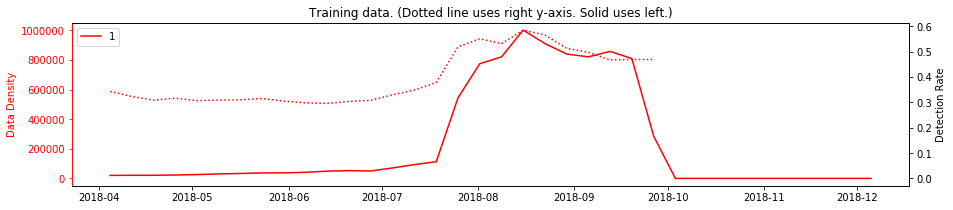

In [4]:
df_train['ones'] = 1
dynamicPlot(df_train,'ones',title='Training data. (Dotted line uses right y-axis. Solid uses left.)')

# Second, view original submission's malware probabilities
We notice that the probabilities before and after the sampling window should be lower. So we should correct them.

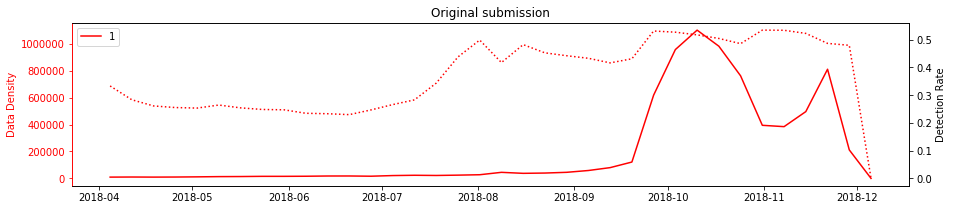

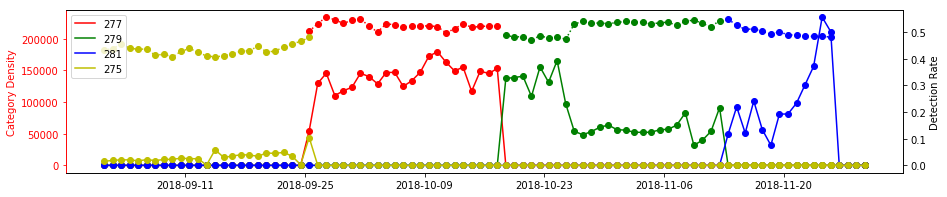

In [5]:
df_test2['ones'] = 1
dynamicPlot(df_test2,'ones',title='Original submission')
dynamicPlot(df_test2,'AvSigVersion2',start=datetime(2018,9,1),end=datetime(2018,11,29),inc_dy=1,top2=4, dots=True)

# Third, adjust probabilities before and after sampling window
We will lower probabilities before September 26, 2018 and after November 20, 2018.

In [6]:
if AdjustPublicScore: df_test2.loc[ (df_test2['AvSigVersion2']==275)|(df_test2['AvSigVersion2']==273),'HasDetections'] *= 0.6

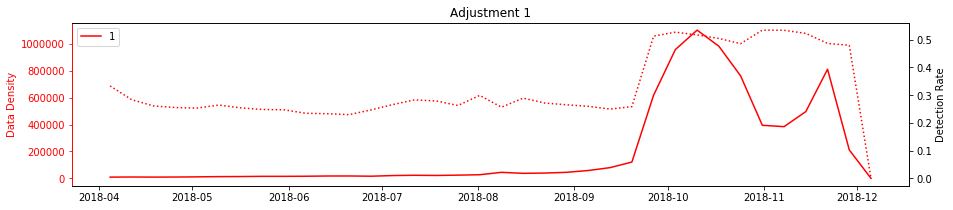

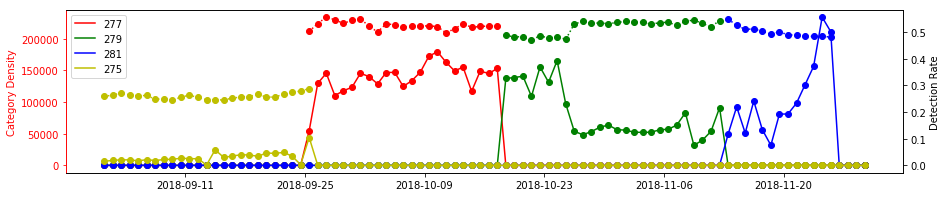

In [7]:
dynamicPlot(df_test2,'ones',title='Adjustment 1')
dynamicPlot(df_test2,'AvSigVersion2',start=datetime(2018,9,1),end=datetime(2018,11,29),inc_dy=1,top2=4, dots=True)

In [8]:
if AdjustPrivateScore==1:
    df_test2.loc[ df_test2['Date']>datetime(2018,11,20,4,0) ,'HasDetections'] = 0
elif AdjustPrivateScore==2:
    df_test2['X'] = df_test2['Date'] - datetime(2018,11,20,4,0) 
    df_test2['X'] = df_test2['X'].map(lambda x: x.total_seconds()/86400)
    df_test2['X'].fillna(0,inplace=True)
    s = 5.813888
    df_test2['F'] = 1.0
    df_test2['F'] = 1 - df_test2['X']/s
    df_test2.loc[df_test2['X']<=0,'F'] = 1.0
    df_test2.loc[df_test2['X']>s,'F'] = 0
    df_test2['HasDetections'] *= df_test2['F']

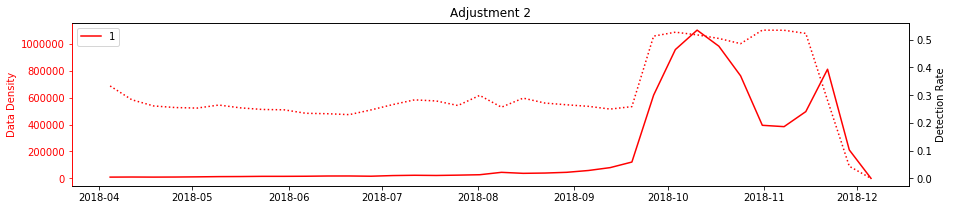

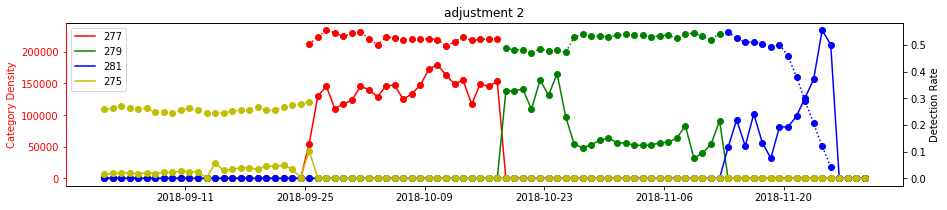

In [9]:
dynamicPlot(df_test2,'ones',title='Adjustment 2')
dynamicPlot(df_test2,'AvSigVersion2',start=datetime(2018,9,1),end=datetime(2018,11,29),inc_dy=1,top2=4,
            dots=True, title='adjustment 2')

# Submit updated submission file
The original submission file had Public/Private LB 0.698/0.635. The new updated file has Public/Private LB 0.693/0.750. Using this trick, one can correct the top Kaggle Microsoft Malware public kernel submission files, ensemble them, and score over 0.700 Public LB (and over 0.750 Private LB).

In [10]:
df_test2[['MachineIdentifier','HasDetections']].to_csv('PrivateLeaderboard.csv', index=False)

![image](http://playagricola.com/Kaggle/private331419.png)